# Political Statements Reliability Analysis
#
Spring 2025 Data Science Project
#
Tutorial by: Naman Nagelia and Emily Cheng
#

# Contributions
Naman: Worked on seciton A, B, D, E,F, I helped make the project idea, and find the data sets, clean them, and helped make the ML models, and worked across to build the sections and text. I cleaned the data and pre plrocessed them, and then developed the models, LightGBM, Random Forest, and Logistic regression.
#
Emily: Worked on B,C, D, E,F, G. I helped with the visualizations, statistical analyses, improving the ML models, putting together the markdown sections and visualization from the models. I took the data and turned it into insights, made charts and hypothesis tested for exploratory data analysis, and improved accuracy on lgihtgbm

# 2. Introduction
# 
In today's fast-paced information age, distinguishing between true and false statements has become more challenging than ever. With the rise of social media and digital news platforms, information spreads at an unprecedented rate, making it difficult to verify credibility. Misinformation can shape public opinion, influence elections, and even impact policy decisions.

To address this challenge, we leverage Natural Language Processing (NLP) to analyze and classify statements based on their truthfulness. Using machine learning models, we aim to identify patterns in language, source credibility, and contextual indicators that differentiate true statements from false, half-true, mostly-true, and barely-true claims.

Our dataset consists of fact-checked statements made by public figures, politicians, and media sources, each labeled with a truthfulness category. By training our model on these labeled statements, we aim to develop an automated classification system that can predict the accuracy of new statements. The ultimate goal is to explore whether computational models can assist in fact-checking by recognizing patterns in language and speaker behavior that are associated with varying levels of reliability.

Throughout this project, we will explore:

Text preprocessing techniques (tokenization, stopword removal, stemming)

Feature extraction

Machine learning models (logistic regression, decision trees, neural networks)

Evaluation metrics (accuracy, precision, recall, F1-score)

While our model will not be perfect, it will serve as a foundation for improving automated fact-checking—a crucial tool in combating misinformation in the digital world.

#
Some questions we will explore include:
- Is this statement factually reliable?
- Which topics are most prone to misinformation?
- Are some speakers more likely than others to tell the truth? How do features like their political party play to this?

# 3. Data Curation


We have 2 datasets from this website which we will use to help determine whether or not a political statement made by an individual with given qualities is likely to be reliable or false. The two datasets have different features and the purpose of this data curation section is to standardize them for consistency,




In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### First Dataset
##### Source: PolitiFact
The first dataset is a tsv file with statements that vary in reliability. We'll read the tsv and turn it into a pandas dataframe, reformat some columns, and drop columns we don't need. 

Description: contains quotes with their truthfulness rating (e.g., True, Mostly True, Half True, Barely True, False, Pants on Fire). Also includes contextual information about the speaker like job title, the audience, the speaker's past statements and their political party.
#


In [3]:
statements = pd.read_csv('statements.tsv', sep='\t')
print(len(statements))
statements.head()

10239


,2635.json,false,Says the Annies List political group supports third-trimester abortions on demand.,abortion,dwayne-bohac,State representative,Texas,republican,0,1,0.1,0.2,0.3,a mailer
0,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.
1,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver
2,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release
3,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN
4,12465.json,true,The Chicago Bears have had more starting quart...,education,robin-vos,Wisconsin Assembly speaker,Wisconsin,republican,0.0,3.0,2.0,5.0,1.0,a an online opinion-piece


Since the dataset doesnt have headers, we set headers based on the description given on the politifact website. The dataset has missing values, represented by NaN, and so we changed all instances of NaN to 0's. 
#
Then, we dropped columns that are irrelevant for our analysis, including state, job title, and id. We also converted the count columns to integers here. 

In [4]:
statements = pd.read_csv('statements.tsv', sep='\t', header=None)
statements.columns = ["id", "reliability", "statement", "subject", "speaker", "job_title", "state", "party", "barely_true_counts", "false_counts", "half_true_counts", "mostly_true_counts", "pants_fire_counts", "audience"]
count_columns = ['barely_true_counts', 'false_counts', 'half_true_counts', 'mostly_true_counts', 'pants_fire_counts']
statements[count_columns] = statements[count_columns].fillna(0).astype(int)
statements.drop(columns = ["state", "job_title", "id"], inplace = True)
display(statements.head())

,reliability,statement,subject,speaker,party,barely_true_counts,false_counts,half_true_counts,mostly_true_counts,pants_fire_counts,audience
0,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,republican,0,1,0,0,0,a mailer
1,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,democrat,0,0,1,1,0,a floor speech.
2,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,democrat,70,71,160,163,9,Denver
3,false,Health care reform legislation is likely to ma...,health-care,blog-posting,none,7,19,3,5,44,a news release
4,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,democrat,15,9,20,19,2,an interview on CNN


The dataset's "subject" column was formatted as a string, often made up of multiple subjects, so we reformatted the column to be a list of subjects so it will be easier to categorize.

In [5]:
statements['subject'].unique()
statements['subject'] = statements['subject'].apply(lambda x: x.split(',') if isinstance(x, str) else x)
statements['subject'] = statements['subject'].apply(lambda x: [item.strip() for item in x] if isinstance(x, list) else x)
statements.head()


,reliability,statement,subject,speaker,party,barely_true_counts,false_counts,half_true_counts,mostly_true_counts,pants_fire_counts,audience
0,false,Says the Annies List political group supports ...,[abortion],dwayne-bohac,republican,0,1,0,0,0,a mailer
1,half-true,When did the decline of coal start? It started...,"[energy, history, job-accomplishments]",scott-surovell,democrat,0,0,1,1,0,a floor speech.
2,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",[foreign-policy],barack-obama,democrat,70,71,160,163,9,Denver
3,false,Health care reform legislation is likely to ma...,[health-care],blog-posting,none,7,19,3,5,44,a news release
4,half-true,The economic turnaround started at the end of ...,"[economy, jobs]",charlie-crist,democrat,15,9,20,19,2,an interview on CNN


We now changed the format of speaker so that the first and last name are separated by a space instead of '-' for better readability and to match the format of speaker in the other dataseet.

In [6]:
statements['speaker'] = statements['speaker'].astype(str).str.lower().str.replace('-', ' ')
statements.head()

,reliability,statement,subject,speaker,party,barely_true_counts,false_counts,half_true_counts,mostly_true_counts,pants_fire_counts,audience
0,false,Says the Annies List political group supports ...,[abortion],dwayne bohac,republican,0,1,0,0,0,a mailer
1,half-true,When did the decline of coal start? It started...,"[energy, history, job-accomplishments]",scott surovell,democrat,0,0,1,1,0,a floor speech.
2,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",[foreign-policy],barack obama,democrat,70,71,160,163,9,Denver
3,false,Health care reform legislation is likely to ma...,[health-care],blog posting,none,7,19,3,5,44,a news release
4,half-true,The economic turnaround started at the end of ...,"[economy, jobs]",charlie crist,democrat,15,9,20,19,2,an interview on CNN


In the dataset, each statement is classified as one of the following: half true, mostly true, true, false, pants fire, or barely true. We want to sort all the statements so that they're classified as either "true" or "false". So, we classified "half true", "mostly true", and "true" as true and then classified "false", "pants fire", and "barely true" as false. 

In [7]:
true = ['half_true', 'mostly_true', 'true']
false = ['false', 'pants_fire', 'barely_true']
statements['verdict'] = statements['reliability'].apply(lambda x: 'true' if x in true else 'false')
display(statements.head())


,reliability,statement,subject,speaker,party,barely_true_counts,false_counts,half_true_counts,mostly_true_counts,pants_fire_counts,audience,verdict
0,false,Says the Annies List political group supports ...,[abortion],dwayne bohac,republican,0,1,0,0,0,a mailer,false
1,half-true,When did the decline of coal start? It started...,"[energy, history, job-accomplishments]",scott surovell,democrat,0,0,1,1,0,a floor speech.,false
2,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",[foreign-policy],barack obama,democrat,70,71,160,163,9,Denver,false
3,false,Health care reform legislation is likely to ma...,[health-care],blog posting,none,7,19,3,5,44,a news release,false
4,half-true,The economic turnaround started at the end of ...,"[economy, jobs]",charlie crist,democrat,15,9,20,19,2,an interview on CNN,false


### Second Dataset
##### Source: PolitiFact

Now we process the second politifact file, a json. We will read the json and turn it into a pandas dataframe, rename the columns to fit the conventions of the first dataframe, and drop the columns we dont need. The dataset is formatted differently and using the similar names from the first dataset and renaming features we can infer our missing values



Description: Contains political quotes with their truthfulness rating (e.g., True, Mostly True, Half True, False, Pants on Fire). Also includes contextual information about the speaker like who they are, the audience, the speaker's past statements and their political party.

In [8]:
statements2 = pd.read_json("politifact_factcheck_data.json", lines=True)
statements2.head()


,verdict,statement_originator,statement,statement_date,statement_source,factchecker,factcheck_date,factcheck_analysis_link
0,true,Barack Obama,John McCain opposed bankruptcy protections for...,6/11/2008,speech,Adriel Bettelheim,6/16/2008,https://www.politifact.com/factchecks/2008/jun...
1,false,Matt Gaetz,"""Bennie Thompson actively cheer-led riots in t...",6/7/2022,television,Yacob Reyes,6/13/2022,https://www.politifact.com/factchecks/2022/jun...
2,mostly-true,Kelly Ayotte,"Says Maggie Hassan was ""out of state on 30 day...",5/18/2016,news,Clay Wirestone,5/27/2016,https://www.politifact.com/factchecks/2016/may...
3,false,Bloggers,"""BUSTED: CDC Inflated COVID Numbers, Accused o...",2/1/2021,blog,Madison Czopek,2/5/2021,https://www.politifact.com/factchecks/2021/feb...
4,half-true,Bobby Jindal,"""I'm the only (Republican) candidate that has ...",8/30/2015,television,Linda Qiu,8/30/2015,https://www.politifact.com/factchecks/2015/aug...


We'll format all the columns just as we had done in the first dataset. Again, we'll separate speaker name by space, rename columns, and drop unneccessary columns. Then, we'll classify the true, false, barely true, half true, mostly true statements as either true or false. 

In [9]:
statements2['statement_originator'] = statements2['statement_originator'].astype(str).str.lower().str.replace('-', ' ')
statements2.rename(columns={'statement_originator': 'speaker', 'verdict': 'reliability', 'statement_source': 'audience'}, inplace=True)
statements2.drop(columns=["factchecker", "factcheck_date", "factcheck_analysis_link"], inplace=True)
statements2['verdict'] = statements2['reliability'].apply(lambda x: 'true' if x in true else 'false')
statements2.head()




,reliability,speaker,statement,statement_date,audience,verdict
0,true,barack obama,John McCain opposed bankruptcy protections for...,6/11/2008,speech,true
1,false,matt gaetz,"""Bennie Thompson actively cheer-led riots in t...",6/7/2022,television,false
2,mostly-true,kelly ayotte,"Says Maggie Hassan was ""out of state on 30 day...",5/18/2016,news,false
3,false,bloggers,"""BUSTED: CDC Inflated COVID Numbers, Accused o...",2/1/2021,blog,false
4,half-true,bobby jindal,"""I'm the only (Republican) candidate that has ...",8/30/2015,television,false


Now as you see, we're still missing many key elements from the first dataframe such as political party and their statement history. Using the names we can infer this, and we will determine the subject of the statement in the next step

In [10]:
speaker_to_party = statements[['speaker', 'party']].drop_duplicates().set_index('speaker')['party'].to_dict()
statements2['party'] = statements2['speaker'].map(speaker_to_party)

counts_columns = ['barely_true_counts', 'false_counts', 'half_true_counts', 'mostly_true_counts', 'pants_fire_counts']
statements['total_counts'] = statements[counts_columns].sum(axis=1)
max_count_rows = statements.loc[statements.groupby('speaker')['total_counts'].idxmax(), ['speaker'] + counts_columns]
statements2 = statements2.merge(max_count_rows, on='speaker', how='left')
statements2.fillna(0, inplace=True)
statements2.drop_duplicates(inplace=True)
statements2.head()




,reliability,speaker,statement,statement_date,audience,verdict,party,barely_true_counts,false_counts,half_true_counts,mostly_true_counts,pants_fire_counts
0,true,barack obama,John McCain opposed bankruptcy protections for...,6/11/2008,speech,true,democrat,70.0,71.0,160.0,163.0,9.0
1,false,matt gaetz,"""Bennie Thompson actively cheer-led riots in t...",6/7/2022,television,false,republican,0.0,1.0,1.0,1.0,0.0
2,mostly-true,kelly ayotte,"Says Maggie Hassan was ""out of state on 30 day...",5/18/2016,news,false,republican,2.0,1.0,1.0,4.0,0.0
3,false,bloggers,"""BUSTED: CDC Inflated COVID Numbers, Accused o...",2/1/2021,blog,false,0,0.0,0.0,0.0,0.0,0.0
4,half-true,bobby jindal,"""I'm the only (Republican) candidate that has ...",8/30/2015,television,false,republican,0.0,1.0,4.0,4.0,0.0


Notice that in statements2, the reliability rating is one of teh following: 'pants-fire', 'false', 'mostly-false', 'half-true', 'mostly-true', 'true'
In the first dataframe, where the reliability rating is one of the following: 'pants-fire', 'false', 'barely-true', 'half-true', 'mostly-true', 'true'
The only difference between the two is that 'mostly-false' appears in statements2, while 'barely-true' appears in statements (the first df). Since these labels convey a similar meaning, we will replace all instances of 'mostly-false' with 'barely-true' in statements2 for consistency."

In [11]:
statements2['reliability'] = statements2['reliability'].replace('mostly-false', 'barely-true')


Now the final column that is missing which is crucial is the subject of the statement. Using keywords, we can infer the topics. In order to classify each statement with relevant subjects, we employ a two-step approach that combines keyword-based inference and text similarity matching using Natural Language Processing (NLP).

To classify each statement with relevant subjects, we employ a two-step approach that combines keyword-based inference and semantic similarity matching using Sentence-BERT (SBERT).

1. Keyword-Based Subject Inference
To infer the subject of a statement, we use a predefined keyword-to-subject mapping. This mapping consists of key topics (e.g., economy, health-care, foreign-policy) and associated keywords commonly found in statements related to those topics.

By scanning each statement for the presence of these keywords, we can automatically infer up to three relevant subjects even if the statement does not explicitly mention the category.

Example Keyword-Based Classification:

A statement containing "inflation" or "GDP" is classified under "economy".

A statement mentioning "medicare" or "hospital" is linked to "health-care".

This method helps us efficiently label statements with topics even when there is no direct subject match in the dataset. However, keyword-based classification has limitations because it does not account for meaning and context.

2. Semantic Similarity-Based Subject Matching using SBERT
Since statements may cover complex or nuanced topics beyond simple keyword matching, we use SBERT embeddings and cosine similarity to match each statement to the most relevant subjects from our predefined topics.

Steps involved:
Convert all statements and subjects into SBERT embeddings – This captures the semantic meaning of both statements and policy topics. Bert considers context in the meaning of the word which is why we use it.

Compute cosine similarity between statement embeddings and subject embeddings – This measures how close a statement is to each policy category.

Identify the top three most similar subjects for each statement – The statement is assigned to the three closest subjects based on their vector representations.



In [12]:
all_topics = statements['subject'].explode().unique()
all_topics
#Looking at all the topics, i classified these manually
subject_map = {
    "abortion": ["abortion"],
    "energy": ["energy", "renewable", "oil", "gas", "coal", "gas-prices", "oil-spill"],
    "economy": ["economy", "inflation", "GDP", "market", "wealth", "deficit", "debt"],
    "jobs": ["jobs", "employment", "workforce", "hiring", "unions", "workers", "labor"],
    "health-care": ["health", "medicare", "insurance", "hospital", "medicaid", "public-health", "health-care"],
    "foreign-policy": ["war", "diplomacy", "treaty", "international", "iraq", "israel", "nuclear", "afghanistan", 'foreign-policy'],
    "elections": ["vote", "polls", "campaign", "ballot", "campaign-advertising", "redistricting", "elections"],
    "ethics": ["corruption", "ethics", "scandal", "fraud", "government-efficiency", "ethics"],
    "crime": ["crime", "criminal-justice", "law", "policing", "public-safety", "crime"],
    "climate-change": ["climate-change", "environment", "cap-and-trade", "climate-change"],
    "government-regulation": ["government-regulation", "market-regulation"],
    "technology": ["technology", "space", "science", "privacy"],
    "immigration": ["immigration", "border", "gays-and-lesbians"],
    "education": ["education", "schools", "teachers", "students"],
    "social-security": ["social-security", "pensions", "retirement"],
    "military": ["military", "veterans", "defense", "homeland-security"],
    "taxes": ["taxes", "financial-regulation", "bankruptcy", "stimulus"],
    "housing": ["housing", "real-estate"],
    "public-health": ["public-health", "disability", "drugs", "marijuana"],
    "transportation": ["transportation", "infrastructure"],
    "sports": ["sports", "baseball", "sports"],
    "religion": ["religion", "islam"],
    "food": ["food", "food-safety", "hunger", "nutrition"],
    "welfare": ["welfare", "poverty", "families"],
    "legal-issues": ["legal-issues", "supreme-court"],
    "public-service": ["public-service", "government-efficiency"],
}


In [13]:
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
model = SentenceTransformer('all-MiniLM-L6-v2')
all_subjects = list(subject_map.keys())
subject_embeddings = model.encode(all_subjects, convert_to_tensor=True)
statement_embeddings = model.encode(statements2["statement"].tolist(), convert_to_tensor=True)
# Compute cosine similarity between statements and subjects
similarity_matrix = cosine_similarity(statement_embeddings.cpu().numpy(), subject_embeddings.cpu().numpy())
top_subjects = []
for i in range(len(statements2)):
    similar_idx = similarity_matrix[i].argsort()[-3:][::-1]  
    subjects = [all_subjects[j] for j in similar_idx]
    top_subjects.append(subjects)

statements2["subject"] = top_subjects
statements2.head()

/opt/anaconda3/envs/320Final/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


,reliability,speaker,statement,statement_date,audience,verdict,party,barely_true_counts,false_counts,half_true_counts,mostly_true_counts,pants_fire_counts,subject
0,true,barack obama,John McCain opposed bankruptcy protections for...,6/11/2008,speech,true,democrat,70.0,71.0,160.0,163.0,9.0,"[welfare, legal-issues, health-care]"
1,false,matt gaetz,"""Bennie Thompson actively cheer-led riots in t...",6/7/2022,television,false,republican,0.0,1.0,1.0,1.0,0.0,"[economy, welfare, immigration]"
2,mostly-true,kelly ayotte,"Says Maggie Hassan was ""out of state on 30 day...",5/18/2016,news,false,republican,2.0,1.0,1.0,4.0,0.0,"[legal-issues, immigration, social-security]"
3,false,bloggers,"""BUSTED: CDC Inflated COVID Numbers, Accused o...",2/1/2021,blog,false,0,0.0,0.0,0.0,0.0,0.0,"[public-health, crime, legal-issues]"
4,half-true,bobby jindal,"""I'm the only (Republican) candidate that has ...",8/30/2015,television,false,republican,0.0,1.0,4.0,4.0,0.0,"[elections, government-regulation, foreign-pol..."


# 4. Exploratory Data Analysis

Now that our data is formatted properly, in this section of the data science life cycle, we are going to visualize the data in order to gain a better understanding of the data between our datasets. Lets first concat both of the DF into one main DF

In [14]:
print(statements.columns)

statements2.drop(columns=['statement_date'], inplace=True)
print(statements2.columns)

statements_main = pd.concat([statements, statements2], ignore_index=True)


Index(['reliability', 'statement', 'subject', 'speaker', 'party',
       'barely_true_counts', 'false_counts', 'half_true_counts',
       'mostly_true_counts', 'pants_fire_counts', 'audience', 'verdict',
       'total_counts'],
      dtype='object')
Index(['reliability', 'speaker', 'statement', 'audience', 'verdict', 'party',
       'barely_true_counts', 'false_counts', 'half_true_counts',
       'mostly_true_counts', 'pants_fire_counts', 'subject'],
      dtype='object')


Next, we'll take a look at the dataframe and its columns to figure out what we will explore in more detail.

In [15]:
print(statements.shape)
print(statements2.shape)
statements_main.shape
statements_main.head()

(10240, 13)
(21150, 12)


,reliability,statement,subject,speaker,party,barely_true_counts,false_counts,half_true_counts,mostly_true_counts,pants_fire_counts,audience,verdict,total_counts
0,false,Says the Annies List political group supports ...,[abortion],dwayne bohac,republican,0.0,1.0,0.0,0.0,0.0,a mailer,false,1.0
1,half-true,When did the decline of coal start? It started...,"[energy, history, job-accomplishments]",scott surovell,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.,false,2.0
2,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",[foreign-policy],barack obama,democrat,70.0,71.0,160.0,163.0,9.0,Denver,false,473.0
3,false,Health care reform legislation is likely to ma...,[health-care],blog posting,none,7.0,19.0,3.0,5.0,44.0,a news release,false,78.0
4,half-true,The economic turnaround started at the end of ...,"[economy, jobs]",charlie crist,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN,false,65.0


### Exploring Distribution of Reliability
Our first step is to analyze the distribution of reliability ratings in our dataset. We accomplish this by using box plots to visualize the count of each category: pants-fire, false, barely-true, half-true, mostly-true, and true. 
#
This allows us to observe how frequently each rating appears, identify any imbalances in the dataset, and gain insights into the overall reliability trends. Understanding this distribution is crucial for ensuring that our model is trained on a well-represented set of labels and can make meaningful predictions.

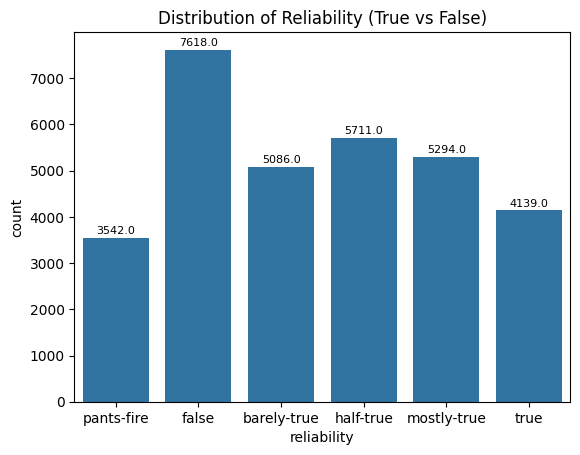

In [16]:

reliability_order = ['pants-fire', 'false', 'barely-true', 'half-true', 'mostly-true', 'true']
ax = sns.countplot(data=statements_main, x='reliability', order=reliability_order)
for p in ax.patches:
    ax.annotate(
        f'{p.get_height()}', 
        (p.get_x() + p.get_width() / 2, p.get_height()), 
        ha='center',  
        va='center', 
        fontsize=8, 
        xytext=(0, 5),  
        textcoords='offset points' 
    )

plt.title('Distribution of Reliability (True vs False)')
plt.show()

Some observations from the plot: 
- The "pants-fire" category, which represents the most extreme form of falsehood and lying, has fewer instances compared to regular "false" statements.
- The "false" category has the highest count, indicating that a significant portion of the statements in the dataset are classified as outright false.
- The counts for "barely-true," "half-true," and "mostly-true" are fairly similar, suggesting a somewhat balanced representation of statements with varying degrees of truthfulness.
- Similarly, the "true" category has the lowest count among the truth-based labels, indicating that fewer statements in the dataset are considered entirely true.

Overall, the dataset has a fairly even distribution of reliability counts, with most categories containing between 4,000 to 5,000 statements. The outliers are the "pants-fire" and "false" categories. Despite these outliers, the diversity in the data should help us create a well-trained and robust model.

However, false statements (pants-fire, false, barely-true) appear more frequently than true statements (half-true, mostly-true, true). Specifically, about 18,600 statements are false, compared to 12,767 true statements. This means approximately 60% of the dataset consists of false statements, which could impact the model's performance. The model may have a tendency to predict "false" more frequently than "true." This is something we'll consider as we build the model, and we may make adjustments if necessary.
# 


### Exploring Political Affiliation
Since such a large proportion of fake news comes from politicians and people in politics, we thought it would be interesting to investigate the relationship between political affiliation and statement reliability. Our dataset has many different parties so we'll first categorize them as democrat, republican, independent, media, or other. 

In [ ]:
# Democrat, republican, independent (moderates or none), or media (organization, newsmakers, journalists, and columnists)

statements_main.party.value_counts()
statements_main['party'] = statements_main['party'].replace({
    "organization": 'media', 
    'newsmaker': 'media', 
    'journalist': 'media', 
    'columnist': 'media', 
    'talk-show-host': 'media',
    'none': 'independent', 
    'Moderate': 'independent', 
    0: 'independent', 
    "moderate": "independent"
})

# Replace specified parties with 'other'
statements_main['party'] = statements_main['party'].replace({
    'libertarian': 'other',
    'activist': 'other',
    'state-official': 'other',
    'labor-leader': 'other',
    'tea-party-member': 'other',
    'business-leader': 'other',
    'green': 'other',
    'education-official': 'other',
    'liberal-party-canada': 'other',
    'government-body': 'other',
    'democratic-farmer-labor': 'other',
    'ocean-state-tea-party-action': 'other',
    'constitution-party': 'other'
})

statements_main['party'].value_counts()


party
independent    11269
republican     11193
democrat        7877
media            734
other            315
Name: count, dtype: int64

Now, we'll perform a chi-squared test of independence to determine if there's a significant relationship between political affiliation and the reliability of the statements they make. Our final model will be classifying statements as "false", "half-true", or "true" so we'll generate a heatmap to visualize this distribution across our 5 different political groups. 

In [24]:
from scipy.stats import chi2_contingency

display(statements_main.head())
true = [ 'mostly-true', 'true']
half_true = ['half-true', 'barely-true']
false = ['false', 'pants-fire']

statements_main['Fake'] = statements_main['reliability'].apply(
    lambda x: 2 if x in true else 1 if x in half_true else 0
)
contingency_table = pd.crosstab(statements_main['party'], statements_main['Fake'])
chi2, p_value, dof, expected = chi2_contingency(contingency_table)
print(f"Chi-squared statistic : {chi2}")
print(f"P-value : {p_value}")
print(f"Degrees of Freedom : {dof}")
print(f"Expected Frequencies:\n{expected}")



,reliability,statement,subject,speaker,party,barely_true_counts,false_counts,half_true_counts,mostly_true_counts,pants_fire_counts,audience,verdict,total_counts,Fake
0,false,Says the Annies List political group supports ...,[abortion],dwayne bohac,republican,0.0,1.0,0.0,0.0,0.0,a mailer,false,1.0,0
1,half-true,When did the decline of coal start? It started...,"[energy, history, job-accomplishments]",scott surovell,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.,false,2.0,0
2,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",[foreign-policy],barack obama,democrat,70.0,71.0,160.0,163.0,9.0,Denver,false,473.0,0
3,false,Health care reform legislation is likely to ma...,[health-care],blog posting,independent,7.0,19.0,3.0,5.0,44.0,a news release,false,78.0,0
4,half-true,The economic turnaround started at the end of ...,"[economy, jobs]",charlie crist,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN,false,65.0,0


Chi-squared statistic : 2581.7522240491567
P-value : 0.0
Degrees of Freedom : 8
Expected Frequencies:
[[2800.16458519 2709.56954887 2367.26586594]
 [4005.97368421 3876.36654135 3386.65977444]
 [ 260.92685103  252.48496241  220.58818657]
 [ 111.97814451  108.35526316   94.66659233]
 [3978.95673506 3850.22368421 3363.81958073]]


In our hypothesis test, our null hypothesis is that there is no relationship between political party and reliability. Our alternative hypothesis is that there is a relationship between political party and reliability. 

Chi-squared Statistic: The calculated Chi-squared statistic is 2581.75, which is very large. A higher Chi-squared value indicates a significant deviation from the expected frequencies, suggesting that there is a strong association between the party and the reliability of statements.

P-value: The p-value is extremely small (0.0), much smaller than the conventional threshold of 0.05 (95% confidence interval), indicating that the result is statistically significant. This means we can reject the null hypothesis (which assumes no relationship) and conclude that there is an association between a person's political party and the likelihood that their statements are classified as "false"

The Chi-squared test results suggest a strong relationship between political party affiliation and the reliability of statements made by individuals, with the p-value being extremely small. This means that the political party a person belongs to significantly influences whether their statements are perceived as "fake" or not. From our own experience witnissing fake news, this is not surprising and this is the result we expected to see. The heatmap visualization below further illustrates this relationship, allowing us to see how each party’s statements are distributed across the "false", "half-true", and "true" categories.



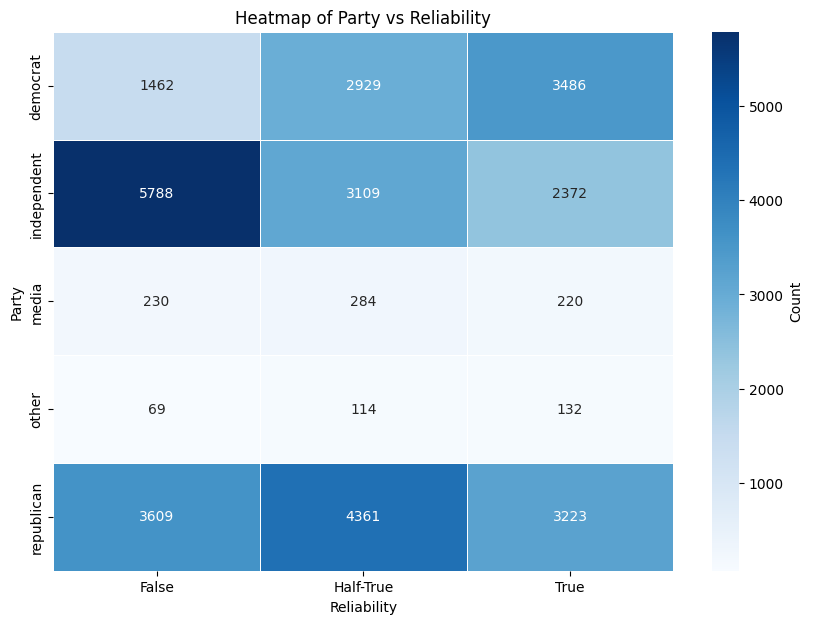

In [26]:
plt.figure(figsize=(10, 7))


heatmap = sns.heatmap(contingency_table, annot=True, fmt="d", cmap="Blues", xticklabels=['False', 'Half-True', 'True'], cbar_kws={'label': 'Count'}, linewidths=0.5)
plt.title('Heatmap of Party vs Reliability')
plt.xlabel('Reliability')
plt.ylabel('Party')
plt.show()

From this heatmap, some observations we see:
- Independents had the highest overall volume of statements, especially in the False category, with 5,788 entries. This may reflect a concentration of unverified or ambiguous sources labeled as “independent,” including unclassified or unaffiliated speakers.

- Republicans had a more even spread across the three classes, with particularly high numbers in the Half-True (4,361) and False (3,609) categories. Their True category count (3,223) is also substantial, suggesting a balanced representation across the truth spectrum.

- Democrats leaned slightly toward the True category (3,486) but also had a high number of Half-True statements (2,929), with fewer in the False class (1,462), indicating relatively stronger performance in truthfulness under this dataset’s labeling.

- Media and Other sources contributed far fewer statements overall. Their distributions are fairly balanced across categories, though the small sample sizes limit statistical interpretation.



### Exploring Relationship Between Past Truthfulness and Statement Reliability
For our last exploration, we will see if there is any correalation between a politician's past statements as evidenced by their past truthfulness counts, and then their statements reliability to see if there is correalated. To do this, we'll use pearson coefficient and a heatmap to visualize this relationship.

The reliability column (made up of pants-fire, false, barely-true, half-true, mostly-true, true) needs to be numeric for us to use a pearson coefficient so we'll do a mapping to number 0-5 with 0 being pants-fire and 5 being true.

/var/folders/99/pgv5k_gn48jfzfdpf9_c12p00000gn/T/ipykernel_33672/3021659947.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['reliability_numeric'] = filtered_data['reliability'].map(reliability_map)


,barely_true_counts,false_counts,half_true_counts,mostly_true_counts,pants_fire_counts,reliability_numeric
barely_true_counts,1.000000,0.924372,0.883864,0.836856,0.498139,-0.004207
false_counts,0.924372,1.000000,0.703503,0.635060,0.690804,-0.081336
half_true_counts,0.883864,0.703503,1.000000,0.985842,0.230402,0.092036
mostly_true_counts,0.836856,0.635060,0.985842,1.000000,0.150134,0.116273
pants_fire_counts,0.498139,0.690804,0.230402,0.150134,1.000000,-0.289079
reliability_numeric,-0.004207,-0.081336,0.092036,0.116273,-0.289079,1.000000


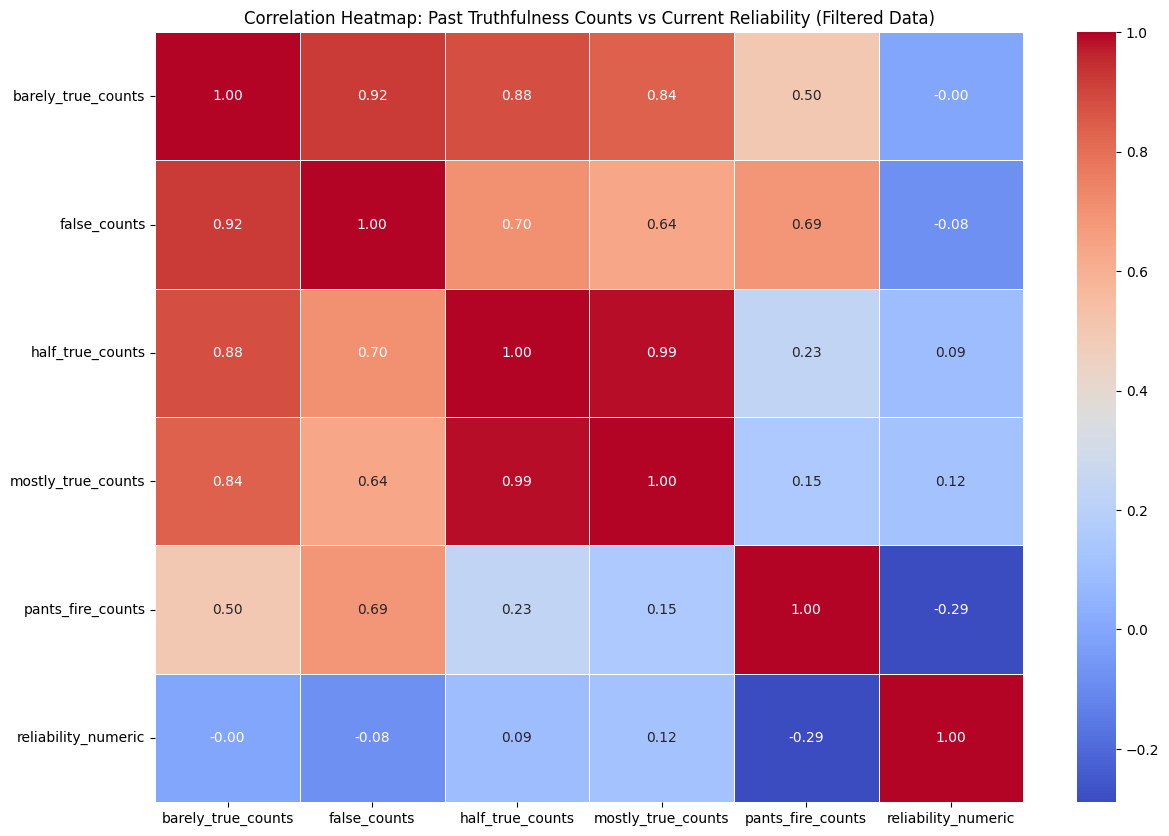

In [29]:
past_truthfulness_columns = ['barely_true_counts', 'false_counts', 'half_true_counts', 'mostly_true_counts', 'pants_fire_counts']

# We only want to include statements that have data on the speaker's past truthfulness
# If there is no data on past reliability, don't include in this analysis
filtered_data = statements_main[statements_main[past_truthfulness_columns].sum(axis=1) > 0]

# Map the current reliability column to numeric values for correlation calculation
reliability_map = {
    'mostly-true': 4,
    'pants-fire': 0,
    'false': 1,
    'true': 5,
    'half-true': 3,
    'barely-true': 2
}

filtered_data['reliability_numeric'] = filtered_data['reliability'].map(reliability_map)

correlation_matrix = filtered_data[past_truthfulness_columns + ['reliability_numeric']].corr(method='pearson')

display(correlation_matrix)

plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", linewidths=0.5, fmt=".2f")
plt.title("Correlation Heatmap: Past Truthfulness Counts vs Current Reliability (Filtered Data)")
plt.show()

Focusing first on past truthfulness counts correlation:
- Barely_true_counts has the highest correlation with other categories, with 0.924 for false_counts, 0.884 for half_true_counts, and 0.837 for mostly_true_counts. This suggests that when a speaker has a history of making statements that are "barely true," these are strongly associated with past counts in varying truthfullness levels which are not fully true or fully false. 

- False_counts has strong correlations with barely_true_counts (0.924) and pants_fire_counts (0.691), which indicates that speakers who frequently make fully false statements also tend to make statements that have varying degrees of falsehood.

- Half_true_counts and mostly_true_counts are very strongly correlated with each other (0.986), suggesting that when a speaker tends to tell "half-true" statements, they also tend to make "mostly-true" statements.

Now, looking at the correlation with reliability_numeric (which represents the current statement's reliability)
- barely_true_counts: There is a very weak correlation (0.003) with reliability_numeric. This indicates that a higher count of barely true statements in the past doesn't seem to significantly affect the reliability of the current statement.

- false_counts: The correlation is -0.077, which is very weak and indicates a very slight negative relationship. In other words, having more past false statements does not strongly correlate with the current statement being reliable or not.

- half_true_counts: The correlation is 0.11, suggesting a slight positive but weak relationship with the current statement's reliability.  This means that a speaker who has often made "half true" statements in the past might slightly be more likely to produce a reliable statement.

- mostly_true_counts: The correlation is 0.134, indicating a very weak positive correlation. This suggests that a speaker who has often made "mostly true" statements in the past might slightly be more likely to produce a reliable statement.

- pants_fire_counts: The correlation is -0.257, indicating a moderate negative correlation. This suggests that speakers who have made more "pants fire" statements in the past are more likely to have a less reliable current statement.

Now, we'll also visualize the relationship between past truthfulness and current statement's validity (using either true or false values). We've classified true, mostly true, and half true as true statements and barely true, false, and pants fire as false statements. 

In [20]:
import pandas as pd
politician_verdicts = statements_main.groupby(["speaker", "verdict"]).size().unstack(fill_value=0)
truthfulness_agg = statements_main.groupby("speaker")[["barely_true_counts", "false_counts", "half_true_counts", "mostly_true_counts", "pants_fire_counts"]].mean().astype(int)
politician_verdicts = politician_verdicts.merge(truthfulness_agg, left_index=True, right_index=True, how="left")

expected_categories = ["true", "false", "barely_true_counts", "false_counts", "half_true_counts", "mostly_true_counts", "pants_fire_counts"]
for category in expected_categories:
    if category not in politician_verdicts.columns:
        politician_verdicts[category] = 0

politician_verdicts.reset_index(inplace=True)
politician_verdicts.head()




,speaker,false,true,barely_true_counts,false_counts,half_true_counts,mostly_true_counts,pants_fire_counts
0,"""watch the water""",1,0,0,0,0,0,0
1,10 gop louisiana lawmakers,1,0,0,0,0,0,0
2,13th district gop slate,1,0,0,0,0,0,0
3,18 percent american public,1,1,0,0,0,0,1
4,18% of the american public,1,0,0,0,0,0,0


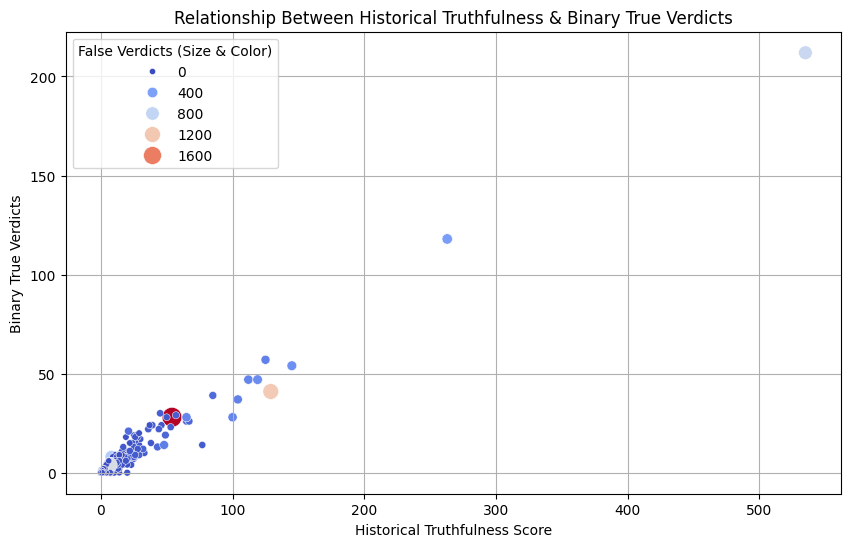

In [21]:
politician_verdicts["historical_truthfulness"] = (
    politician_verdicts["true"] + 
    politician_verdicts["half_true_counts"] + 
    politician_verdicts["mostly_true_counts"]
)

politician_verdicts["historical_falsehood"] = (
    politician_verdicts["false"] + 
    politician_verdicts["barely_true_counts"] + 
    politician_verdicts["pants_fire_counts"]
)

# Creating scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x="historical_truthfulness", 
    y="true", 
    size="false", 
    hue="false", 
    data=politician_verdicts, 
    sizes=(20, 200), 
    palette="coolwarm"
)

plt.title("Relationship Between Historical Truthfulness & Binary True Verdicts")
plt.xlabel("Historical Truthfulness Score")
plt.ylabel("Binary True Verdicts")
plt.legend(title="False Verdicts (Size & Color)")
plt.grid(True)
plt.show()


From the scatterplot, we can see that the there is a general upward trend, suggesting that as a person's historical truthfulness score increases, the number of true verdicts they receive also increases.This indicates that individuals with a history of truthful statements tend to continue making more truthful statements.

The size and color of the points represent the count of false verdicts. Larger and more reddish points indicate individuals with higher counts of false statements.

Most points appear smaller and blue, meaning that a majority of individuals have relatively fewer false verdicts. Some points with high false verdicts (larger, reddish) are concentrated in the lower-left region, suggesting that individuals with a low historical truthfulness score tend to have more false statements. There are a few outliers, namely the large dark red dog who has a mix of both true and false verdicts.





# 5. Primary Analysis #

From our data exploration, we decided to incorporate the features of statement text, the speaker's identity and political party, the subject, and a set of numeric count features (representing historical patterns in the speaker's prior statements) in our model. 

For our primary analysis, we chose a classification approach to predict the factual reliability of statements. In our data exploration, we examined the relationships between political affiliation and reliability, as well as how a speaker’s history of truthfulness relates to the factual accuracy of new statements. We experimented with multiple approaches to classification, including using all six original classes, reducing them to a binary classification (true vs. false), and grouping them into three categories: true, half-true, and false. Ultimately, we chose the three-class approach as it offers a balanced compromise between preserving meaningful distinctions and maintaining interpretability in model performance.

This requires the model to assign each statement to one of three categories: false, half-true, or true. To do this, we'll use logistic regression, random forest, and LightGBM and analyze which models perform the best.

To build and evaluate our classification models, we relied on several libraries from Python:
- scikit-learn (sklearn): This machine learning library provided essential tools for model training, evaluation, and preprocessing. We used train_test_split to divide data, TfidfVectorizer for converting text into numerical features, and LogisticRegression and RandomForestClassifier for modeling. Performance was evaluated using metrics like accuracy_score and classification_report. We also used preprocessing tools like OneHotEncoder, MultiLabelBinarizer, and StandardScaler to encode categorical data and scale numerical features, and GridSearchCV to tune hyperparameters.

- lightgbm (lgb): This framework was used to train tree-based models. Its ability to handle large-scale, high-dimensional data made it ideal for capturing complex feature relationships in our classification task.

- scipy.sparse: Functions like hstack and csr_matrix were used to efficiently combine large, sparse feature matrices (e.g., text vectors and encoded categories) without consuming excessive memory.

- numpy: As a foundational numerical library, NumPy supported vectorized operations and data transformations throughout the project.

- TruncatedSVD: This dimensionality reduction technique helped reduce the size of our TF-IDF feature space, improving computational efficiency while preserving meaningful variance in the text data.

### Logistic Regression Model

Logistic Regression is a simple yet effective model well-suited for multi-class text classification tasks, particularly when interpretability is important. In this implementation, we use TF-IDF vectorization to transform the statement text into numerical features, limiting the vocabulary to the top 5,000 terms to balance expressiveness and computational efficiency. In addition to the textual data, we incorporate contextual features including one-hot encoded representations of the speaker and political party, binary indicators for the statement’s subject, and standardized numeric counts capturing the speaker’s historical truthfulness based on prior verdicts. The model is trained on 80% of the data, with 20% reserved for testing, using stratified sampling to preserve the original class distribution.

In [30]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import OneHotEncoder, MultiLabelBinarizer, StandardScaler
from scipy.sparse import hstack, csr_matrix
import numpy as np

count_columns = ['barely_true_counts', 'false_counts', 'half_true_counts', 'mostly_true_counts', 'pants_fire_counts']

statements_main[count_columns] = statements_main[count_columns].fillna(0).astype(int)
statements_main['subject'] = statements_main['subject'].apply(lambda x: x if isinstance(x, list) else [])
# label_mapping = {
#     'true': 5,
#     'mostly-true': 4,
#     'half-true': 3,
#     'barely-true': 2,
#     'false': 1,
#     'pants-fire': 0
# }
# statements_main['reliability_numeric'] = statements_main['reliability'].map(label_mapping)
def group_labels(x):
    if x in ['true', 'mostly-true']:
        return 2  
    elif x in ['half-true', 'barely-true']:
        return 1 
    else:
        return 0  

statements_main['reliability_numeric'] = statements_main['reliability'].apply(group_labels)

tfidf = TfidfVectorizer(max_features=5000, stop_words='english')
X_text = tfidf.fit_transform(statements_main['statement'])
speaker_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
X_speaker = speaker_encoder.fit_transform(statements_main[['speaker']])

party_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
X_party = party_encoder.fit_transform(statements_main[['party']])
subject_encoder = MultiLabelBinarizer()
X_subject = subject_encoder.fit_transform(statements_main['subject'])
scaler = StandardScaler()
X_counts_scaled = scaler.fit_transform(statements_main[count_columns])

X_speaker_sparse = csr_matrix(X_speaker)
X_party_sparse = csr_matrix(X_party)
X_subject_sparse = csr_matrix(X_subject)
X_counts_sparse = csr_matrix(X_counts_scaled)
X = hstack([X_text, X_speaker_sparse, X_party_sparse, X_subject_sparse, X_counts_sparse])
y = statements_main['reliability_numeric']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

lr_model = LogisticRegression(
    solver='saga',
    max_iter=5000,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)
lr_model.fit(X_train, y_train)

y_pred_lr = lr_model.predict(X_test)

print("Logistic Regression Results:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_lr):.4f}")
print(classification_report(y_test, y_pred_lr, target_names=['False', 'Half-True', 'True']))


Logistic Regression Results:
Accuracy: 0.6180
              precision    recall  f1-score   support

       False       0.68      0.66      0.67      2232
   Half-True       0.58      0.54      0.56      2159
        True       0.59      0.66      0.63      1887

    accuracy                           0.62      6278
   macro avg       0.62      0.62      0.62      6278
weighted avg       0.62      0.62      0.62      6278



This model uses a three-class framework to categorize statements as False, Half-True, or True, the logistic regression model achieved an overall accuracy of 61.8%. The model performed best on the False class, with an F1-score of 0.67, followed by the True class at 0.63, while performance on the Half-True class was slightly lower, with an F1-score of 0.56. These results suggest that logistic regression can effectively separate clearly reliable and unreliable statements, but tends to struggle more with statements that fall in the middle of the truthfulness spectrum. 

### Random Forest Model

To enhance the model’s ability to capture non-linear relationships within the data, a Random Forest classifier was used for the three-class classification task. Random Forestconstructs a collection of decision trees and combines their predictions to produce more generalized results. Since our dataset requires analyzing language, categorical variables, and numeric indicators, a random forest is better equiped to identify these non-linear patterns between features.

In [31]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

rf_model = RandomForestClassifier(random_state=42)
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None]
}
grid_search = GridSearchCV(rf_model, param_grid, cv=5,
                           scoring='f1_macro', n_jobs=-1)
grid_search.fit(X_train, y_train)
best_rf = grid_search.best_estimator_
y_pred_rf = best_rf.predict(X_test)

print("Random Forest Results (Best Parameters: {}):".format(
    grid_search.best_params_))
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")
print(classification_report(y_test, y_pred_rf, target_names=['False', 'Half-True', 'True']))


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Random Forest Results (Best Parameters: {'max_depth': None, 'n_estimators': 200}):
Accuracy: 0.7705
              precision    recall  f1-score   support

       False       0.77      0.84      0.80      2232
   Half-True       0.76      0.71      0.73      2159
        True       0.79      0.77      0.78      1887

    accuracy                           0.77      6278
   macro avg       0.77      0.77      0.77      6278
weighted avg       0.77      0.77      0.77      6278



The Random Forest classifier performed much stronger than the logistic regression, achieving an overall accuracy of 77.1%. The model showed balanced performance across all classes, with F1-scores of 0.80 for False, 0.73 for Half-True, and 0.78 for True. It demonstrated strong recall for the False class (0.84) and consistently high precision across all categories. These results suggest that the model was highly effective at distinguishing between different levels of truthfulness, even when the differences were subtle. 

### LightGBM

Can we get even better accuracy? To further improve classification performance and handle the complexity of the features, we applied a LightGBM (Light Gradient Boosting Machine) model to the three-class reliability prediction task. LightGBM is a powerful tree-based method, which will be useful because of its speed and ability to capture non-linear relationships in large and high-dimensional datasets. 

In [ ]:
import lightgbm as lgb
import numpy as np
from sklearn.model_selection import train_test_split
from scipy.sparse import hstack, csr_matrix
from sklearn.preprocessing import OneHotEncoder, MultiLabelBinarizer, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, accuracy_score
from sklearn.decomposition import TruncatedSVD

count_columns = ['barely_true_counts', 'false_counts',
                 'half_true_counts', 'mostly_true_counts', 'pants_fire_counts']

statements_main[count_columns] = statements_main[count_columns].fillna(
    0).astype(int)
statements_main['subject'] = statements_main['subject'].apply(
    lambda x: x if isinstance(x, list) else [])

tfidf = TfidfVectorizer(max_features=5000, stop_words='english')
X_text = tfidf.fit_transform(statements_main['statement'])

# To enhance performance, reduce dimension of text
# After plotting dimension vs accuracy, using n_components=300 yields the highest accuracy
svd = TruncatedSVD(n_components=300, random_state=42)
X_text_reduced = svd.fit_transform(X_text)
speaker_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
X_speaker = speaker_encoder.fit_transform(statements_main[['speaker']])

party_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
X_party = party_encoder.fit_transform(statements_main[['party']])

subject_encoder = MultiLabelBinarizer()
X_subject = subject_encoder.fit_transform(statements_main['subject'])

scaler = StandardScaler()
X_counts_scaled = scaler.fit_transform(statements_main[count_columns])

X_speaker_sparse = csr_matrix(X_speaker)
X_party_sparse = csr_matrix(X_party)
X_subject_sparse = csr_matrix(X_subject)
X_counts_sparse = csr_matrix(X_counts_scaled)

X = hstack([X_text_reduced, X_speaker_sparse, X_party_sparse,
           X_subject_sparse, X_counts_sparse])

def group_labels(x):
    if x in ['true', 'mostly-true']:
        return 2
    elif x in ['half-true', 'barely-true']:
        return 1
    else:
        return 0


statements_main['reliability_grouped'] = statements_main['reliability'].apply(
    group_labels)
y = statements_main['reliability_grouped']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

lgb_model = lgb.LGBMClassifier(
    objective='multiclass',
    num_class=3,
    boosting_type='gbdt',
    num_leaves=127,     
    max_depth=8,          
    learning_rate=0.03,    
    n_estimators=1500,     
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.2,
    reg_lambda=0.5,
    class_weight='balanced', 
    random_state=42,
)

lgb_model.fit(X_train, y_train)
y_pred_lgb = lgb_model.predict(X_test)


print("LightGBM Results (Grouped Classes):")
print(f"Accuracy: {accuracy_score(y_test, y_pred_lgb):.4f}")
print(classification_report(y_test, y_pred_lgb,
      target_names=['False', 'Half-True', 'True']))

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.037880 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 77219
[LightGBM] [Info] Number of data points in the train set: 25112, number of used features: 594
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] N

/opt/anaconda3/envs/320Final/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


LightGBM Results (Grouped Classes):
Accuracy: 0.7971
              precision    recall  f1-score   support

       False       0.80      0.85      0.82      2232
   Half-True       0.77      0.75      0.76      2159
        True       0.82      0.80      0.81      1887

    accuracy                           0.80      6278
   macro avg       0.80      0.80      0.80      6278
weighted avg       0.80      0.80      0.80      6278



The LightGBM classifier achieved the highest overall accuracy of 79.7%, showing strong performance in predicting statement reliability across the three classes: False, Half-True, and True. The model performed consistently well across all categories, with F1-scores ranging from 0.76 to 0.82, and particularly high recall for the False class (0.85), suggesting it was especially effective at identifying clearly unreliable statements. Precision and recall were balanced for all classes, reflected in a macro-averaged F1-score of 0.80, demonstrating good performance regardless of class size.

# 6. Visualization #

Now that we've developed our LightGBM model, we can visualize the results.

### Predicted vs Observed Category Bar Chart

This bar chart compares the percentage of statements that fall into each truthfulness category—False, Half-True, and True—for both the actual dataset (blue bars) and the model's predictions (red bars). The goal is to assess whether the model preserves the original distribution of classes or introduces any bias.

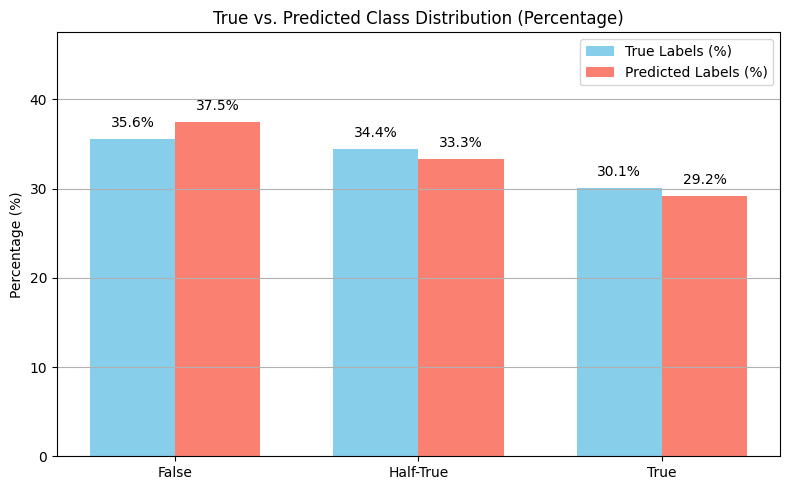

In [37]:
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

# Define class labels
class_names = ['False', 'Half-True', 'True']

# Count occurrences in true and predicted labels
true_counts = Counter(y_test)
pred_counts = Counter(y_pred_lgb)

# Convert to percentages
total_true = sum(true_counts.values())
total_pred = sum(pred_counts.values())

true_percents = [100 * true_counts.get(i, 0) / total_true for i in range(3)]
pred_percents = [100 * pred_counts.get(i, 0) / total_pred for i in range(3)]

# Create bar positions
x = np.arange(len(class_names))
width = 0.35

# Plotting
fig, ax = plt.subplots(figsize=(8, 5))
bars1 = ax.bar(x - width/2, true_percents, width, label='True Labels (%)', color='skyblue')
bars2 = ax.bar(x + width/2, pred_percents, width, label='Predicted Labels (%)', color='salmon')

for i in range(len(class_names)):
    ax.text(x[i] - width/2, true_percents[i] + 1, f'{true_percents[i]:.1f}%', ha='center', va='bottom', fontsize=10)
    ax.text(x[i] + width/2, pred_percents[i] + 1, f'{pred_percents[i]:.1f}%', ha='center', va='bottom', fontsize=10)
# Labels and formatting
ax.set_ylabel('Percentage (%)')
ax.set_title('True vs. Predicted Class Distribution (Percentage)')
ax.set_xticks(x)
ax.set_xticklabels(class_names)
ax.set_ylim(0, max(true_percents + pred_percents) + 10)
ax.legend()
plt.grid(axis='y')
plt.tight_layout()
plt.show()



The bar chart compares the percentage distribution of actual versus predicted labels across the three truthfulness categories: False, Half-True, and True. Overall, the model’s predictions align closely with the true label distribution, showing that it is well-calibrated and not heavily biased toward any single class. 

For the False category, the model slightly overpredicts, labeling 37.5% of statements as false compared to the true rate of 35.6%, indicating a slight tendency to flag more statements as incorrect than what is actually incorrect. 

The Half-True class shows a nearly perfect match, with the predicted percentage just 1.1 points lower than the actual value (33.3% vs. 34.4%). 

Similarly, the True category is slightly underpredicted by less than one percentage point (29.2% predicted vs. 30.1% actual). These small deviations suggest the model preserves the general shape and balance of the original class distribution, making it a reliable tool for multi-class classification of statement reliability.

### Per-Class Model Performance

This bar chart illustrates the model’s performance for each of the three truthfulness categories (False, Half-True, and True) based on three key evaluation metrics: precision, recall, and F1-score.

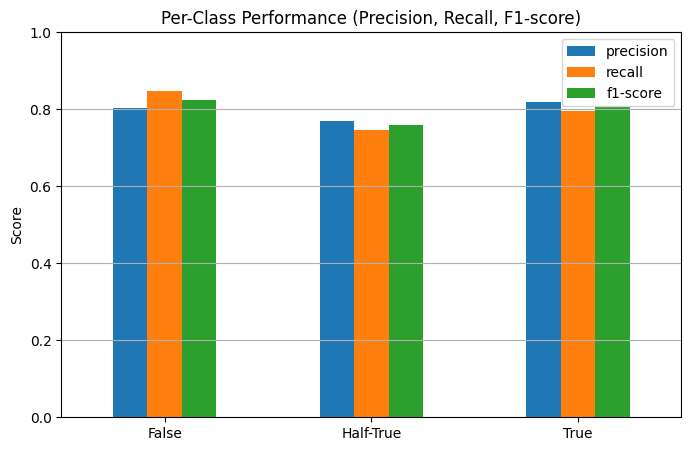

In [ ]:
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import pandas as pd

report = classification_report(y_test, y_pred_lgb, output_dict=True, target_names=['False', 'Half-True', 'True'])
df = pd.DataFrame(report).T[:-3]  

df[['precision', 'recall', 'f1-score']].plot(kind='bar', figsize=(8, 5))
plt.title('Per-Class Performance (Precision, Recall, F1-score)')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.show()


Some observations
- The model performs strongest on False statements, with the highest recall (~0.85), indicating that most actual false statements were correctly identified. Precision and F1-score are also strong (around 0.80–0.82), showing both correctness and balance in predictions for this class.

- Performance is slightly lower for Half-True statements across all metrics, with precision, recall, and F1-score clustering around 0.75–0.77. This suggests the model finds these statements more ambiguous or harder to distinguish, possibly due to their nuanced nature lying between truth and falsehood.

- The model shows good precision (~0.82) for True statements, meaning when it predicts a statement is true, it’s likely correct. Recall is slightly lower but still strong (~0.79), and the F1-score is balanced between the two.

Our model performs best on clearly false statements, effectively detecting them. True statements are also well predicted, but with slightly less recall. Half-true statements remain the most difficult to classify, unsurprising because of their inherent subjectivity. 

### Predicted vs Actual Label Distributions Across Parties



/var/folders/99/pgv5k_gn48jfzfdpf9_c12p00000gn/T/ipykernel_33672/366081981.py:35: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.text(x[i] - width/2, actual_vals[i] + 1, f'{actual_vals[i]:.1f}%', ha='center')
/var/folders/99/pgv5k_gn48jfzfdpf9_c12p00000gn/T/ipykernel_33672/366081981.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.text(x[i] + width/2, pred_vals[i] + 1, f'{pred_vals[i]:.1f}%', ha='center')


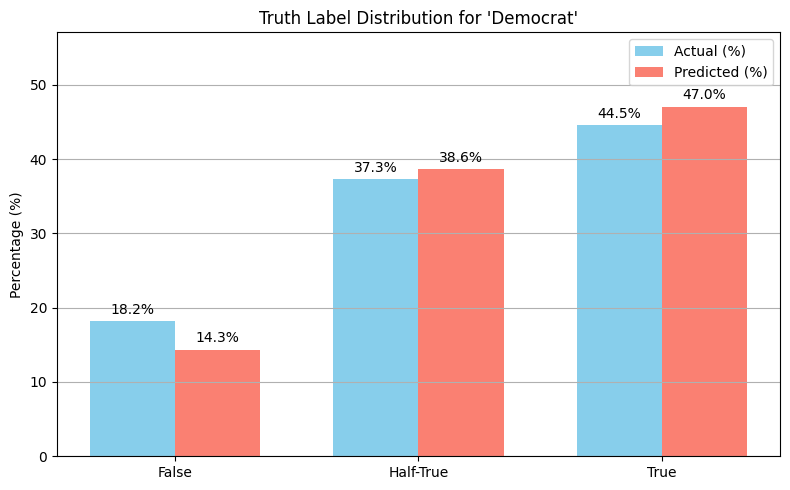

/var/folders/99/pgv5k_gn48jfzfdpf9_c12p00000gn/T/ipykernel_33672/366081981.py:35: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.text(x[i] - width/2, actual_vals[i] + 1, f'{actual_vals[i]:.1f}%', ha='center')
/var/folders/99/pgv5k_gn48jfzfdpf9_c12p00000gn/T/ipykernel_33672/366081981.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.text(x[i] + width/2, pred_vals[i] + 1, f'{pred_vals[i]:.1f}%', ha='center')


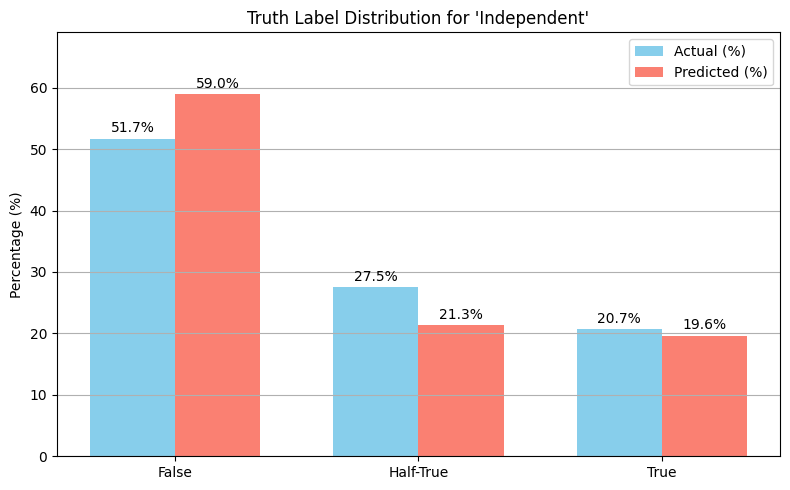

/var/folders/99/pgv5k_gn48jfzfdpf9_c12p00000gn/T/ipykernel_33672/366081981.py:35: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.text(x[i] - width/2, actual_vals[i] + 1, f'{actual_vals[i]:.1f}%', ha='center')
/var/folders/99/pgv5k_gn48jfzfdpf9_c12p00000gn/T/ipykernel_33672/366081981.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.text(x[i] + width/2, pred_vals[i] + 1, f'{pred_vals[i]:.1f}%', ha='center')


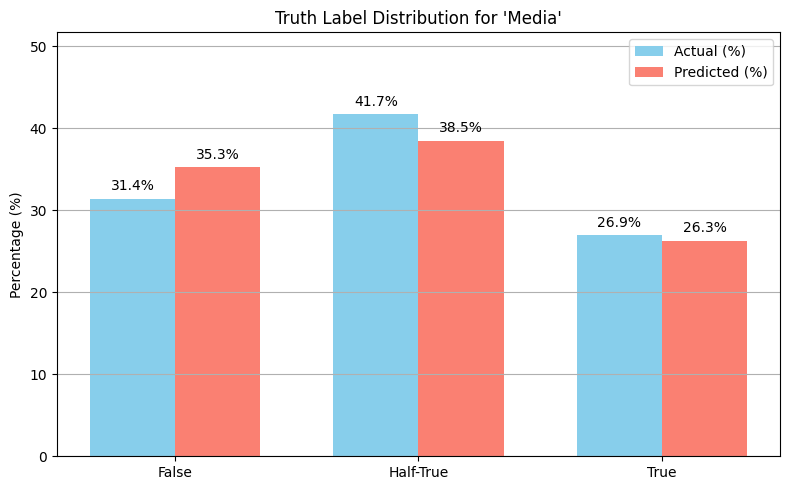

/var/folders/99/pgv5k_gn48jfzfdpf9_c12p00000gn/T/ipykernel_33672/366081981.py:35: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.text(x[i] - width/2, actual_vals[i] + 1, f'{actual_vals[i]:.1f}%', ha='center')
/var/folders/99/pgv5k_gn48jfzfdpf9_c12p00000gn/T/ipykernel_33672/366081981.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.text(x[i] + width/2, pred_vals[i] + 1, f'{pred_vals[i]:.1f}%', ha='center')


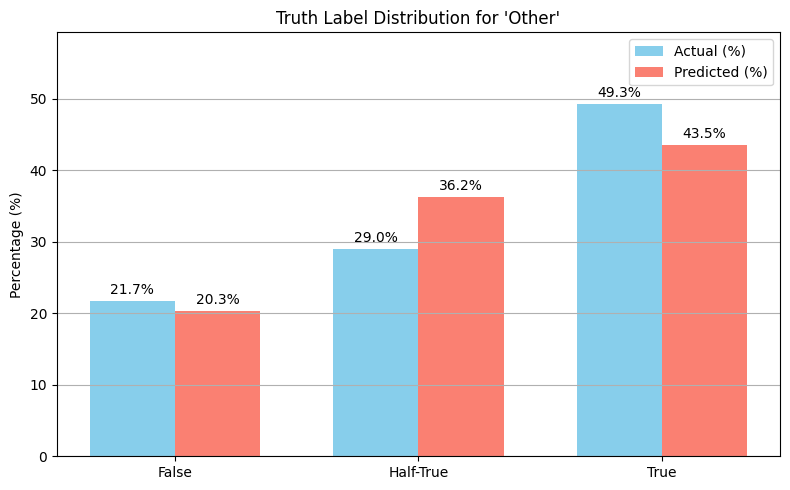

/var/folders/99/pgv5k_gn48jfzfdpf9_c12p00000gn/T/ipykernel_33672/366081981.py:35: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.text(x[i] - width/2, actual_vals[i] + 1, f'{actual_vals[i]:.1f}%', ha='center')
/var/folders/99/pgv5k_gn48jfzfdpf9_c12p00000gn/T/ipykernel_33672/366081981.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.text(x[i] + width/2, pred_vals[i] + 1, f'{pred_vals[i]:.1f}%', ha='center')


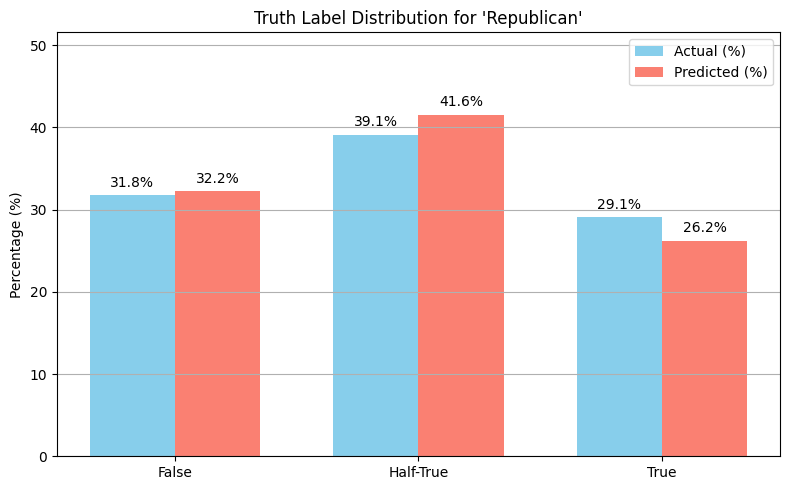

In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
class_names = ['False', 'Half-True', 'True']
class_mapping = {0: 'False', 1: 'Half-True', 2: 'True'}
test_results = statements_main.loc[y_test.index].copy()
test_results['Actual'] = y_test.map(class_mapping)
test_results['Predicted'] = y_pred_lgb
test_results['Predicted_Label'] = test_results['Predicted'].map(class_mapping)
actual_dist = pd.crosstab(test_results['party'], test_results['Actual'], normalize='index') * 100
pred_dist = pd.crosstab(test_results['party'], test_results['Predicted_Label'], normalize='index') * 100
parties = actual_dist.index.intersection(pred_dist.index)
for party in parties:
    actual_vals = actual_dist.loc[party, class_names]
    pred_vals = pred_dist.loc[party, class_names]

    x = np.arange(len(class_names))
    width = 0.35

    fig, ax = plt.subplots(figsize=(8, 5))
    ax.bar(x - width/2, actual_vals, width, label='Actual (%)', color='skyblue')
    ax.bar(x + width/2, pred_vals, width, label='Predicted (%)', color='salmon')

    for i in range(len(class_names)):
        ax.text(x[i] - width/2, actual_vals[i] + 1, f'{actual_vals[i]:.1f}%', ha='center')
        ax.text(x[i] + width/2, pred_vals[i] + 1, f'{pred_vals[i]:.1f}%', ha='center')

    ax.set_title(f"Truth Label Distribution for '{party.title()}'")
    ax.set_xticks(x)
    ax.set_xticklabels(class_names)
    ax.set_ylabel("Percentage (%)")
    ax.set_ylim(0, max(actual_vals.max(), pred_vals.max()) + 10)
    ax.legend()
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()


- Democrats: The model slightly underpredicts “False” labels (14.3% predicted vs. 18.2% actual). “Half-True” predictions (38.6%) are close to the actual (37.3%). The model slightly overpredicts “True” labels (47.0% predicted vs. 44.5% actual).

- Independent: “False” statements are notably overpredicted (59.0% vs. 51.7%). “Half-True” and “True” are both underpredicted.

- Media: Slight overprediction of “False” (35.3% vs. 31.4%) and underprediction of “Half-True” (38.5% vs. 41.7%). “True” predictions match well (26.3% vs. 26.9%).

- Other: Underprediction of “True” labels (43.5% predicted vs. 49.3% actual). Overprediction of “Half-True” (36.2% vs. 29.0%).

- Republican: The distribution is fairly close to actual values. “False” (32.2% predicted vs. 31.8% actual). “Half-True” (41.6% vs. 39.1%). Slight underprediction for “True” (26.2% vs. 29.1%)

The model appears well-balanced across most parties but shows a consistent tendency to slightly overpredict “False” labels—particularly for Independents. True labels are most underpredicted for Independents and Others, suggesting the model may need better calibration or representation for these subgroups. Democrat and Republican distributions are closest to actual, indicating better model performance on more frequently represented classes.



### Confusion Matrix

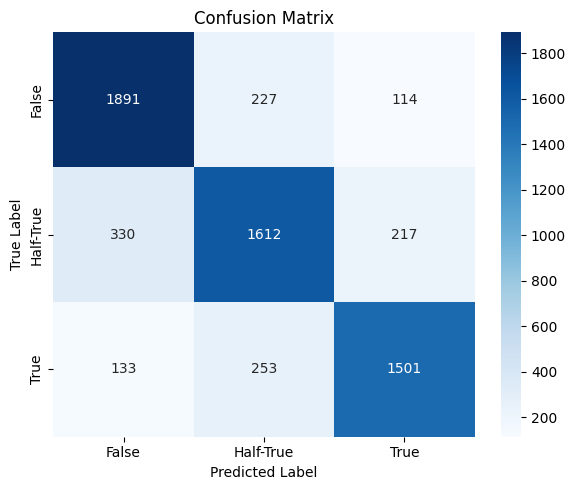

In [ ]:
from sklearn.metrics import confusion_matrix

class_mapping = {0: 'False', 1: 'Half-True', 2: 'True'}


statements_main['GroupedLabel'] = statements_main['reliability'].apply(group_labels)

test_results = statements_main.loc[y_test.index].copy()
test_results['Predicted'] = y_pred_lgb
test_results['Predicted_Label'] = test_results['Predicted'].map(class_mapping)
party_vs_pred = pd.crosstab(test_results['party'], test_results['Predicted_Label'], normalize='index') * 100

conf_mat = confusion_matrix(y_test, y_pred_lgb)
conf_df = pd.DataFrame(conf_mat, index=class_mapping.values(), columns=class_mapping.values())

plt.figure(figsize=(6, 5))
sns.heatmap(conf_df, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

This confusion matrix provides a clear visualization of how well the model is predicting each of the three grouped truthfulness classes (false, half-true, and true). The values on the diagonal (top-left to bottom-right) represent correct predictions.
- False: 1,891 out of 2,232 total False instances were correctly labeled (~85%).

- Half-True: 1,612 out of 2,159 were correct (~75%).

- True: 1,501 out of 1,887 were correct (~80%).

Overall, most predictions lie along the diagonal, showing strong model performance. The model struggles the most with the Half-True category, with notable confusion both upward (to True) and downward (to False). False and True categories are more confidently classified, but some overlap still exists, likely due to ambiguous or borderline cases.



### Reliability Across Grouped Subjects
This stacked bar chart visualizes the predicted truthfulness of statements across various grouped subject categories. Each bar represents a topic (e.g., healthcare, immigration, economy), and is segmented into three colors showing the percentage of predictions labeled as False, Half-True, or True.

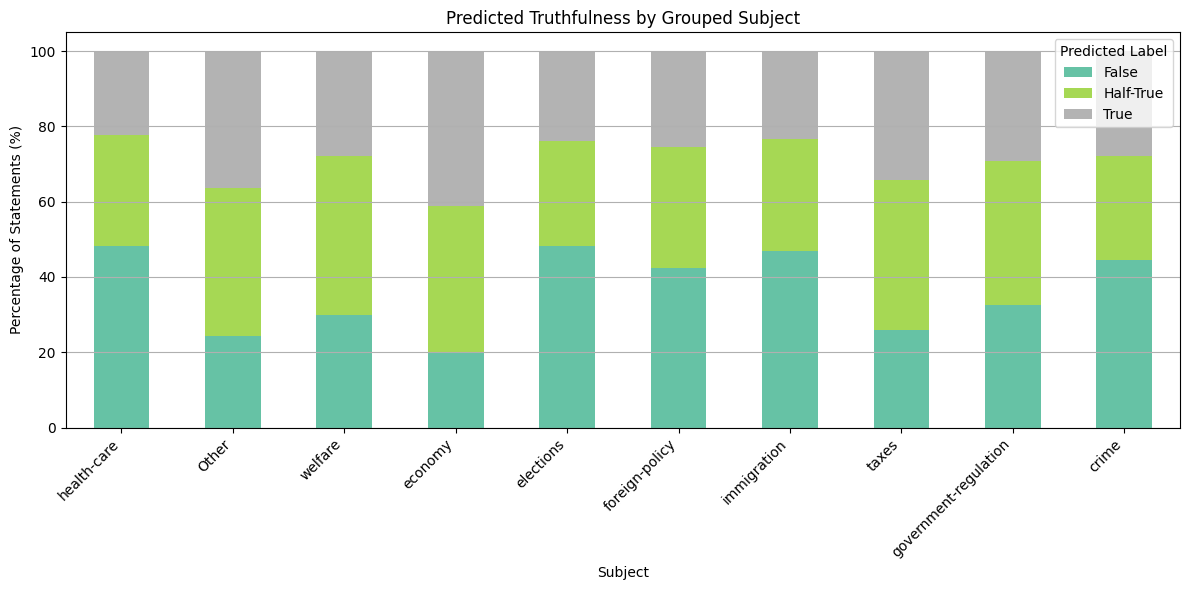

In [53]:
test_results = statements_main.loc[y_test.index].copy()
test_results['Predicted'] = y_pred_lgb
test_results['Predicted_Label'] = test_results['Predicted'].map(class_mapping)

test_results_exploded = test_results.explode('subject')

def map_subject(topic):
    for group, keywords in subject_map.items():
        if topic in keywords:
            return group
    return 'Other'

test_results_exploded['Grouped_Subject'] = test_results_exploded['subject'].apply(map_subject)

grouped_crosstab = pd.crosstab(
    test_results_exploded['Grouped_Subject'],
    test_results_exploded['Predicted_Label'],
    normalize='index'
) * 100
top_subjects = test_results_exploded['Grouped_Subject'].value_counts().head(10).index
grouped_crosstab = grouped_crosstab.loc[top_subjects]

grouped_crosstab.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='Set2')
plt.title("Predicted Truthfulness by Grouped Subject")
plt.ylabel("Percentage of Statements (%)")
plt.xlabel("Subject")
plt.xticks(rotation=45, ha='right')
plt.legend(title="Predicted Label")
plt.grid(axis='y')
plt.tight_layout()
plt.show()


Some observations from the plot: 
- Health-care, elections, and immigration show the highest share of False predictions, suggesting these topics are more prone to misinformation or contentious claims.

- Welfare and crime have relatively higher proportions of True predictions, indicating statements in these areas may be more fact-based or less disputed.

- Economy and foreign policy show a balanced distribution, with similar shares of all three truth categories. This suggests a mix of factually sound and misleading claims, possibly due to the complexity or politicization of these topics.

- The "Other" category has a noticeable concentration in Half-True predictions, possibly reflecting ambiguity or mixed accuracy in less common or uncategorized topics.

This visualization helps identify which subjects are most likely to feature misinformation based on model predictions. For instance, a policymaker or platform moderator might prioritize health-care or immigration-related claims for fact-checking, given their higher false prediction rates. Conversely, subjects like crime or welfare might require less immediate scrutiny.

# 7. Insights and Conclusion


This project set out to address a critical challenge: how to evaluate the factual reliability of political statements in a world increasingly shaped by misinformation. Our objective was to use machine learning to classify statements as True, Half-True, or False, based on their text content and a range of contextual features. In doing so, we aimed to answer three essential questions: Is a given statement factually reliable? Which topics are most prone to misinformation? And are certain speakers more likely to tell the truth than others?

To tackle these questions, we engineered a rich dataset that combined TF-IDF representations of statement text with metadata including the speaker's name, political party, subject categories, and historical truthfulness records. By comparing Logistic Regression, Random Forest, and LightGBM models, we found that LightGBM consistently delivered the strongest performance, with an accuracy of nearly 80% and well-balanced precision and recall across the three truthfulness classes. 

From our modeling and visual analyses, we uncovered several important patterns:

- On the question of factual reliability, we found that our model is highly capable of distinguishing between clearly true and clearly false statements, though it occasionally struggles with statements that fall into the ambiguous middle ground of "Half-True"—which reflects the nuanced nature of real-world discourse.

- In exploring which topics are most prone to misinformation, subject-level features like healthcare, immigration, and elections policy frequently appeared in statements flagged as False or Half-True. This aligns with real-world trends, where these complex policy areas are often the focus of misleading or oversimplified claims.

- As for speaker reliability, our inclusion of historical truthfulness counts revealed consistent patterns. Speakers with a track record of making truthful statements were more likely to issue new statements that the model also predicted as true, and vice versa. We also noted subtle differences across political parties—such as independents receiving more "False" predictions overall—raising important questions about bias in either the data or real-world political communication patterns.

Our visualizations supported these findings, showing clear differences in label distributions across party lines and demonstrating how model predictions compare to actual data. For example, while Democrats were most often associated with "True" labels, Independents had a much higher proportion of statements classified as "False." These findings are particularly relevant in the context of media literacy and algorithmic transparency, as they highlight the need to understand not only what predictions models make, but also why they make them.

Looking ahead, there are several valuable ways this project could be extended and improved. One of the most immediate opportunities lies in increasing the size and diversity of the dataset. By incorporating more political statements from a broader range of sources, including more recent or international content, the model could become more robust and generalizable across different contexts. Additionally, enhancing the quality and balance of class labels, especially the underrepresented or more ambiguous categories, could reduce prediction bias and improve performance on borderline cases. Another promising direction is to integrate additional contextual features, such as audience type, geographic region, or source credibility scores, which may provide further insight into patterns of truthfulness. Finally, with further refinement and testing, this system could be adapted into a real-time tool or browser extension, alerting users to the likely reliability of claims as they consume information online.

This project demonstrates the effectiveness of machine learning in classifying speech. The techniques developed here could be extended to build real-time credibility assessment tools for journalists, fact-checkers, or the general public. However, the results also underscore the importance of careful feature selection, model evaluation, and ethical considerations—especially when models have the power to influence public perception. As misinformation continues to pose social and political challenges, tools like these can play a valuable role in promoting a more informed and discerning public.
